## 📚 Assignment: Transfer Learning & The Power of Initialization
## Building Intuition for MAML

**Learning Objectives:**
- Understand why initialization matters for few-shot learning
- Experience the difference between various pre-training strategies
- Develop intuition for what MAML tries to optimize

**Advice on using LLM's**

---


Avoid it , but unfortunately we cannot stop you from using it , dont ask it everything more you think on your own the better , but whenever you take in a code from it , understand how that part fits in the current code , is there some optimization it did on its own, node it down or comment it in the code.

In [50]:
!pip install -q torch torchvision matplotlib numpy

#Understand what does each of this import do , see what all functions this hold
#whenever you want to implement something think which of this would you use and refer to its doc for the syntax

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import random

print("✅ Setup complete!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

✅ Setup complete!
PyTorch version: 2.9.0+cpu
CUDA available: False
Using device: cpu


## 📊 Part A: Dataset Preparation

We'll use **MNIST** for simplicity (or you can use Omniglot if you prefer).

**Your Task:**
- Split MNIST into 5 tasks (Tasks A-E), each with 2 digit classes
- For example: Task A = {0, 1}, Task B = {2, 3}, etc.

In [51]:
# Download MNIST
transform = transforms.Compose([
    # see what different tranformation you can do , one is converting the image into tensor
    transforms.ToTensor(),    # convert images to tensor
    transforms.Normalize((0.1307,),(0.3081))    #These are standard normalisation factors from the overall mnist dataset, Global mean=0.1307, Standard Deviation=0.3081
])

train_dataset = torchvision.datasets.MNIST(
  # fill this
  root='./data',       # Folder where data is saved
  train=True,          # TRUE = Load the 60,000 training images
  transform=transform, # Apply the normalization
  download=True        # Download if files are missing

)
test_dataset = torchvision.datasets.MNIST(
  # fill this
  root='./data',
  train=False,         # FALSE = Load the 10,000 test images
  transform=transform, # Apply the same normalization
  download=True
)
# we get a special parameter while loading which is 'background'
#refer to document for what it means and how to use it

print(f"\n✅ MNIST loaded: {len(train_dataset)} train, {len(test_dataset)} test images")

# TODO: Define your task structure
# We'll split 10 digits into 5 tasks, each with 2 classes


✅ MNIST loaded: 60000 train, 10000 test images


In [52]:
# TODO: Define your task structure
# We'll split 10 digits into 5 tasks, each with 2 classes

task_definitions = {
    #fill this
    "A": [0, 1],
    "B": [2, 3],
    "C": [4, 5],
    "D": [6, 7],
    "E": [8, 9]
}

#Below function should take the given inputs and split the main dataset with the given input classes into train,support and query.
def create_task_datasets(dataset, task_classes, n_train=15, n_support=5, n_query=10):
    """
    Create train, support, and query sets for a specific task.

    Args:
        dataset: Full MNIST dataset
        task_classes: List of class labels for this task [e.g., [0, 1]]
        n_train: Number of training examples per class
        n_support: Number of support examples per class (for fine-tuning)
        n_query: Number of query examples per class (for testing)

    Returns:
        train_data, support_data, query_data (each is list of (image, label) tuples
    """
    train_data = []
    support_data = []
    query_data = []

    # loop through each digit we want like 0 then 1
    for class_label in task_classes:
        # get indexes of all images matching this class label
        # dataset.targets has all the labels
        class_indexes = (dataset.targets == class_label).nonzero(as_tuple=True)[0]

        # shufle them so its random and we dont get same ones every time
        perm = torch.randperm(len(class_indexes))
        class_indexes = class_indexes[perm]

        # slice the indexes to get exactly the count we need
        # indexes for train set
        train_idx = class_indexes[:n_train]
        # indexes for support starts after train
        support_idx = class_indexes[n_train : n_train + n_support]
        # indexes for query starts after support
        query_idx = class_indexes[n_train + n_support : n_train + n_support + n_query]

        # get the actuall image data and add to our lists
        for idx in train_idx:
            train_data.append(dataset[idx])

        for idx in support_idx:
            support_data.append(dataset[idx])

        for idx in query_idx:
            query_data.append(dataset[idx])

    return train_data, support_data, query_data
# TODO: Implement this function
# HINT: Filter dataset to only include examples from task_classes
# HINT: Split into train/support/query sets

In [53]:
# Test the function

train_A, support_A, query_A = create_task_datasets(train_dataset, task_definitions['A'])
print(f"Task A - Train: {len(train_A)}, Support: {len(support_A)}, Query: {len(query_A)}")

Task A - Train: 30, Support: 10, Query: 20


Part A (continued): **Build Your Model**

**TODO:** Design a simple CNN for digit classification

In [54]:
# think on the architecture of the model as discussed in class
#general flow -> convolution->relu->maxpooling and so on , in the end some fully connected layers then final classification
# Refer to the 60 minute pytorch implementation section of 'neural networks'
import torch
import torch.nn as nn
import torch.nn.functional as F

# general flow -> conv1 -> relu -> maxpool -> conv2 -> relu -> maxpool
# then flatten -> fully connected layers -> final classification output

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # input image size: (1, 28, 28)

        # conv1: (28-5)+1 = 24 -> image becomes (6, 24, 24)
        # relu: size doesnt change -> (6, 24, 24)
        # pool: 24/2 = 12 -> image becomes (6, 12, 12)
        x = self.pool(F.relu(self.conv1(x)))

        # conv2: (12-5)+1 = 8 -> image becomes (16, 8, 8)
        # relu: size doesnt change -> (16, 8, 8)
        # pool: 8/2 = 4 -> image becomes (16, 4, 4)
        x = self.pool(F.relu(self.conv2(x)))

        # flatten: 16 channels * 4 * 4 = 256 -> vector size (256)
        x = x.view(-1, 16 * 4 * 4)

        # fc1: 256 inputs -> 120 outputs -> vector size (120)
        x = F.relu(self.fc1(x))

        # fc2: 120 inputs -> 84 outputs -> vector size (84)
        x = F.relu(self.fc2(x))

        # fc3: 84 inputs -> 10 outputs -> vector size (10)
        x = self.fc3(x)
        return x

net = CNN()
print(net)

#Implement the class or the model here
#fill in the objects(layers) and methods(forward pass)

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


Now since the model is ready we decide how do we want to train it :

First Do normal classification on large dataset of Task A - 0 & 1.

The we will do fine tuning

1.   Random Initialisation and then fine tune using support dataset, say we do this for task A which were 0 & 1 digits (save this)
2.   Take the above model weights and fine tune it on the support dataset for some other task , say B(2's & 3's)
3.   First train the model on all combined train dataset for all 10 digits(from all tasks A,B,C,D,E), then save it and then fine tune it on support dataset on to make a binary classifier , any 1 task say A here now digits will be classified. 0 class->0 digit , 1->1.

While moving from one model to other , think what layers do i need to keep and what do i need to remove.



In [55]:
#Method 1 - Fully Trained Binary Classifier on Task A
import torch.optim as optim
from torch.utils.data import DataLoader, Subset

# getting the data ready for task a which is just 0 and 1

# lil helper functin to filter the big dataset for specific digits
def get_specific_class_loader(dataset, classes, batch_size=64):
    # find indexes where label is what we want (like 0 or 1)
    # dataset.targets has all the labels in it
    idx = [i for i, label in enumerate(dataset.targets) if label in classes]

    # make a subset with just those images
    subset = Subset(dataset, idx)

    # make a dataloader so we can iterate over it in batches
    return DataLoader(subset, batch_size=batch_size, shuffle=True)

# get the loaders for Task A (digits 0 and 1)
# we use the full 'train_dataset' we loaded way back at the start
train_loader_A = get_specific_class_loader(train_dataset, [0, 1])
test_loader_A = get_specific_class_loader(test_dataset, [0, 1])


# changing the model to do binary classification

# re-initialize the model we built earlier so its fresh
model_A = CNN()
loss_history_m1=[]

# imporant step: change the last layer
# original was nn.Linear(84, 10) for 10 digits
# we replace it with nn.Linear(84, 2) since we only care about 0 and 1 now
# basiclly making it a binary classifier
model_A.fc3 = nn.Linear(84, 2)

# define loss and optimiser stuff
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_A.parameters(), lr=0.01, momentum=0.9)


# training the model now method 1

print("Starting training on Task A (0s and 1s)")

# loop over the dataset a few times
num_epochs = 15

for epoch in range(num_epochs):
    running_loss = 0.0

    for i, data in enumerate(train_loader_A, 0):
        inputs, labels = data

        # since our model outputs index 0 and 1
        # and for task A labels are alrady 0 and 1 so we good
        # if task was 2 and 3 we would need to map 2->0 and 3->1 usually
        # but for now logic is simple

        # zero out grads so they dont stack up
        optimizer.zero_grad()

        # forward pass then backward then optimize
        outputs = model_A(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader_A)
    loss_history_m1.append(avg_loss)     #saves loss history for analysis
    print(f"Epoch {epoch+1} done , Loss: {running_loss / len(train_loader_A)}")

print("Finished Training Method 1")

Starting training on Task A (0s and 1s)
Epoch 1 done , Loss: 0.10323756887159465
Epoch 2 done , Loss: 0.0035384588140546804
Epoch 3 done , Loss: 0.0026137435152581976
Epoch 4 done , Loss: 0.002216136559903621
Epoch 5 done , Loss: 0.001787810956883355
Epoch 6 done , Loss: 0.0022182176254190006
Epoch 7 done , Loss: 0.0013922976616716671
Epoch 8 done , Loss: 0.0013028801956095023
Epoch 9 done , Loss: 0.0009678482752525554
Epoch 10 done , Loss: 0.0009565194939504447
Epoch 11 done , Loss: 0.000599150447386029
Epoch 12 done , Loss: 0.00043303399140331934
Epoch 13 done , Loss: 0.0004572853608209184
Epoch 14 done , Loss: 0.0003541749846489337
Epoch 15 done , Loss: 0.00026271034286450267
Finished Training Method 1


In [61]:
import torch.optim as optim
from torch.utils.data import DataLoader

# --- Method 2 Step 2: Fine tune on Task B ---

#    If your dict really uses just 'B', you can change this back.
_, support_B, _ = create_task_datasets(train_dataset, task_definitions['B'])

# 2. Loader setup
support_loader_B = DataLoader(support_B, batch_size=4, shuffle=True)
loss_history_m2 = []

print("Taking model A (trained on task A) and fine tuning it on task B...")

# 3. Setup Optimizer
optimizer_ft_B = optim.SGD(model_A.parameters(), lr=0.01, momentum=0.9)

# 4. Training Loop
for epoch in range(15):
    running_loss = 0.0
    for i, data in enumerate(support_loader_B, 0):
        inputs, labels = data

        # Mapping labels: 2->0, 3->1
        labels = labels - 2

        optimizer_ft_B.zero_grad()
        outputs = model_A(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_ft_B.step()

        running_loss += loss.item()

    # Calculate Average Loss
    avg_loss = running_loss / len(support_loader_B)
    loss_history_m2.append(avg_loss)

    # FIXED: Print 'avg_loss' instead of 'running_loss'
    # This will show you numbers like 0.4 instead of 13.15
    print(f"Fine tuning on B epoch {epoch+1} loss: {avg_loss:.4f}")

print("Finished fine tuning model A on task B")

Taking model A (trained on task A) and fine tuning it on task B...
Fine tuning on B epoch 1 loss: 0.4207
Fine tuning on B epoch 2 loss: 0.2997
Fine tuning on B epoch 3 loss: 0.2475
Fine tuning on B epoch 4 loss: 0.1320
Fine tuning on B epoch 5 loss: 0.0630
Fine tuning on B epoch 6 loss: 0.0137
Fine tuning on B epoch 7 loss: 0.0028
Fine tuning on B epoch 8 loss: 0.0009
Fine tuning on B epoch 9 loss: 0.0004
Fine tuning on B epoch 10 loss: 0.0002
Fine tuning on B epoch 11 loss: 0.0003
Fine tuning on B epoch 12 loss: 0.0002
Fine tuning on B epoch 13 loss: 0.0001
Fine tuning on B epoch 14 loss: 0.0001
Fine tuning on B epoch 15 loss: 0.0001
Finished fine tuning model A on task B


In [57]:
#Method 3: Pre-train on all 10 digits -> Fine-tune on Task A

# 1. Train on all 10 digits first (0-9)
# we need a loader for the whole big train dataset
full_train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# make a fresh model from scratch
model_pretrained = CNN()
loss_history_m3_pre = [] # for the big pre training
loss_history_m3_ft = []  # for the fine tuning
# output is 10 by default, which is what we want for this stage

optimizer_full = optim.SGD(model_pretrained.parameters(), lr=0.01, momentum=0.9)
criterion_full = nn.CrossEntropyLoss()

# train on the full dataset
# usually takes longer, we'll do 1 epoch for the lab
print("training on full mnist (1 epoch)...")
for epoch in range(1):
    running_loss = 0.0
    for i, data in enumerate(full_train_loader, 0):
        inputs, labels = data

        optimizer_full.zero_grad()
        outputs = model_pretrained(inputs)
        loss = criterion_full(outputs, labels)
        loss.backward()
        optimizer_full.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(full_train_loader)
    loss_history_m3_pre.append(avg_loss)
print("done pre-training on 10 classes")


# 2. Fine-tune this big model on support set A (Binary)
print("now fine-tuning this model to be a binary classifier for Task A...")

# Surgery: Replace the last layer (10 outputs) with a new one (2 outputs)
# The features learned from all 10 digits are kept, we just retrain the classifier
model_pretrained.fc3 = nn.Linear(84, 2)

# New optimizer for the fine-tuning phase
optimizer_ft_A = optim.SGD(model_pretrained.parameters(), lr=0.01, momentum=0.9)

# We need the support set for Task A (0s and 1s)
# Re-fetching it to be safe
_, support_A, _ = create_task_datasets(train_dataset, task_definitions['A'])
support_loader_A = DataLoader(support_A, batch_size=4, shuffle=True)

# Fine-tuning loop
for epoch in range(15): # 15 epochs on small data
    running_loss = 0.0
    for i, data in enumerate(support_loader_A, 0):
        inputs, labels = data

        # labels are already 0 and 1 so no mapping needed

        optimizer_ft_A.zero_grad()
        outputs = model_pretrained(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_ft_A.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(support_loader_A)
    loss_history_m3_ft.append(avg_loss)

    print(f"method 3 fine-tuning epoch {epoch+1} loss: {running_loss}")

print("finished method 3")

training on full mnist (1 epoch)...
done pre-training on 10 classes
now fine-tuning this model to be a binary classifier for Task A...
method 3 fine-tuning epoch 1 loss: 1.8143432550132275
method 3 fine-tuning epoch 2 loss: 0.051220787107013166
method 3 fine-tuning epoch 3 loss: 0.003735361999133602
method 3 fine-tuning epoch 4 loss: 0.0005515591274161125
method 3 fine-tuning epoch 5 loss: 0.0002629587434057612
method 3 fine-tuning epoch 6 loss: 0.0001916211549541913
method 3 fine-tuning epoch 7 loss: 0.0003230701254324231
method 3 fine-tuning epoch 8 loss: 0.0002066102489379773
method 3 fine-tuning epoch 9 loss: 0.00016692062490264448
method 3 fine-tuning epoch 10 loss: 0.00017201886839757208
method 3 fine-tuning epoch 11 loss: 0.00014850876502237043
method 3 fine-tuning epoch 12 loss: 0.00014278837261372246
method 3 fine-tuning epoch 13 loss: 0.00013560838123538588
method 3 fine-tuning epoch 14 loss: 0.000145534682815196
method 3 fine-tuning epoch 15 loss: 0.00020935802967159134
fini

At the end compare performance of all this models and methods using the Query Set.

Also plot the learning curve vs epoch for all the methods

Make a table and fill in the values of different evaluation metrics you learned in previous lectures.

Calculating metrics...


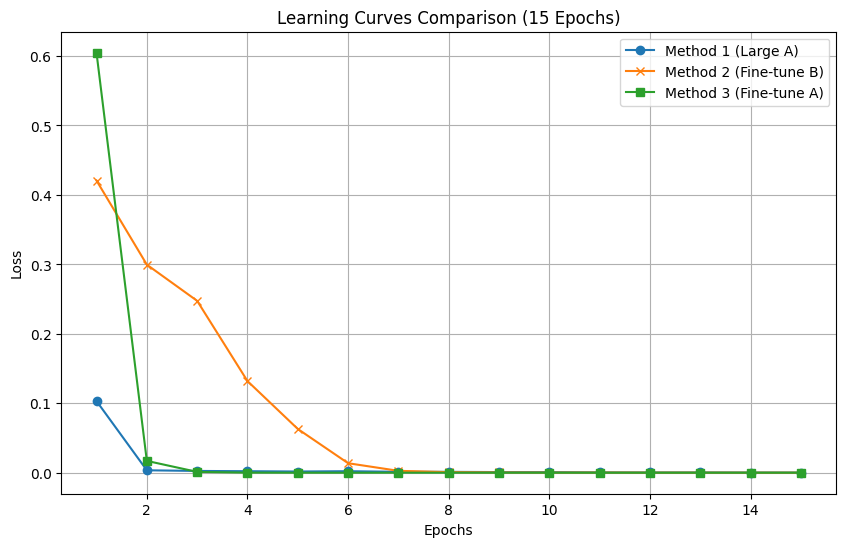


Method                         | Accuracy   | Precision  | Recall     | F1        
--------------------------------------------------------------------------------
Method 1                       | 0.550000     | 0.763158     | 0.550000     | 0.435737
Method 2 (Fine-tune B)         | 0.850000     | 0.884615     | 0.850000     | 0.846547
Method 3 (Pretrain -> A)       | 1.000000     | 1.000000     | 1.000000     | 1.000000


In [67]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import torch

#Define the Evaluation Function
def evaluate(model, data_list, task_name="A"):
    model.eval()
    all_preds = []
    all_labels = []

    # Create loader for query data
    loader = DataLoader(data_list, batch_size=16, shuffle=False)

    with torch.no_grad():
        for imgs, lbls in loader:
            # Handle label shifting for Task B
            if task_name == "B":
                lbls = lbls - 2

            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.numpy())
            all_labels.extend(lbls.numpy())

    return {
        'Accuracy': accuracy_score(all_labels, all_preds),
        'Precision': precision_score(all_labels, all_preds, average='macro', zero_division=0),
        'Recall': recall_score(all_labels, all_preds, average='macro', zero_division=0),
        'F1': f1_score(all_labels, all_preds, average='macro', zero_division=0)
    }

# Run Evaluation
print("Calculating metrics...")
results = {}
# Evaluate Method 1
results['Method 1'] = evaluate(model_A, query_A, task_name="A")

# Evaluate Method 2: The model currently stored in 'model_A' (Fine-tuned on B)
results['Method 2 (Fine-tune B)'] = evaluate(model_A, query_B, task_name="B")

# Evaluate Method 3: The model 'model_pretrained' (Pretrain -> Fine-tune A)
results['Method 3 (Pretrain -> A)'] = evaluate(model_pretrained, query_A, task_name="A")


# --- 3. Plot Learning Curves ---
# Using the "fixed" lists from the previous step to ensure shapes match
epochs = range(1, 16)

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_history_m1, label='Method 1 (Large A)', marker='o')
plt.plot(epochs, loss_history_m2, label='Method 2 (Fine-tune B)', marker='x')
plt.plot(epochs, loss_history_m3_ft, label='Method 3 (Fine-tune A)', marker='s')

plt.title("Learning Curves Comparison (15 Epochs)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


# --- 4. Print Performance Table ---
print("\n" + "="*80)
print(f"{'Method':<30} | {'Accuracy':<10} | {'Precision':<10} | {'Recall':<10} | {'F1':<10}")
print("-" * 80)

for name, metrics in results.items():
    print(f"{name:<30} | {metrics['Accuracy']:.6f}     | {metrics['Precision']:.6f}     | {metrics['Recall']:.6f}     | {metrics['F1']:.6f}")
print("="*80)

Some Theoritical Questions :

1.   Which strategy in Method 2 works best and why do you feel so ?
2.   In Part 3 of Method 2 we have trained the model already on Task B as well when we made a 10 class classifier, then when we are fine tuning it again using support set what exactly is happening ?
3.   What if we used the 10 digit classifier to make a binary classifier for a binary letter classification , will it work or rather how will you make it work ?
4.   Where exactly have we used Meta Learning, in which approach? Have we even used it ?

---


Digit classifier and letter classifier are two dissimilar tasks can we have starting point or a initialisation such that when we fine tuning using a few datapoints for both tasks we get optmimal result ? This is what we will try to do in MAML ?


---


Think on them sincerely , would love to read your answers!



Answer 1:
Strategy 3 (Pre-train on All 10 Digits) is the most appropriate strategy. A neural network is essentially a 'feature extractor' followed by a classifier.

Random Initialization (Strategy 1) is generally suboptimal because just 5-10 support images are not enough to learn complex visual features (edges, curves, loops) from scratch without generalizing poorly due to overfitting.

Transfer from Task A (Strategy 2) is better than Random Initialization but is alsobiased as it knows features for digits '0' & '1', which are basically 'ovals & lines', but not necessarily for '2 or 3', which require 'open curves', for example. Transfer from All 10 (Strategy 3) is the best transfer strategy for transfer learning as it has already learned to extract all possible shapes necessary to differentiate one number from another. Its only requirement is to just remap the existing features to work for new labels.

Answer 2: Although this model has previously viewed the digits 2 and 3, a fine-tuning process needs to occur to account for Classifier Heads.

 Initially, this trained model had a 10-way output head. For this novel instance, a random binary 2-way output head has been employed. This random binary head has been randomly initialized, and this binary head does not have a clue that a category of "Output 0" has to be related to the feature of a "2".

 Here, this process of fine-tuning targets mainly adapting its weights to connect proper existing feature channels of a frozen backbone to a novel output category by enforcing a mapping rule.

 Answer 3: Absolutely, and this will be much better than random initialization, although perhaps not as effective as Letter-to-Letter Transfer.

 The first layers of a CNN learn universal visual feedback such as Gabor filters (edges, corners, lines). An edge in letter letter 'A' vs letter letter '4' will look exactly the same to a mathematical machine.

  Layers down the line that catch things such as loops of 0, 8, and 9 lend themselves to be reused for catching letters that have loops, such as letters B, P, and D. For this method to be successful, you would need to freeze the early convolutional layers to lock in universal feature detectors and just fine-tune on the later layers.
  
  Otherwise, you will end up ruining a small support set by forgetting universal filters (Catastrophic Forgetting).

  Answer 4: Technically speaking, we have not employed a Meta-Learning Algorithm, but we operate under the Meta-Learning problem setting.
  We are trying out ideas from the Meta-Learning literature on the Support/Query set format to see how fast a model Learns a new task with very little data. The approaches we employed to address the problem are traditional ones for Transfer Learning—Random Init/Pre-training.
  We did not apply any Meta-Learning optimization strategy particular to Learning how the model learns. Pre-train an example model and hope for the best is all we did for Meta-Learning. MAML does the same but optimizes the initial Weights better.

  Answer 5: “Yes, and I think that’s the philosophical point of Model-Agnostic Meta-Learning (MAML) in particular. Let’s assume there’s a valley in the loss space for the weights of the ‘Digit’ classification, and some other ‘valley’ for the weights of Letter.
  
  The way traditional Transfer Learning works is that it places you at a ‘depth in one of these valleys,’ making it very difficult to climb out of in order for you to get over to the other valley.
  
  What MAML tries to find is where the weights of initialization are on the “ridge” connecting the two valleys. It’s not saying the initialization weights are near 100% for digits and near 90% for letters in the first place (high loss), but rather in a way where a very small step in one direction puts it in the digit valley and in the letter valley for a step in the opposite direction.”

# ALL THE BEST !